In [5]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [6]:
df = pd.read_csv(r"C:\Churn_Prediction\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [10]:
df.drop('customerID', axis=1, inplace=True)

In [11]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

In [16]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [17]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

In [18]:
def evaluate_model(y_test, y_pred, y_prob):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [19]:
evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

Accuracy: 0.7838452787258248
Precision: 0.6118251928020566
Recall: 0.5096359743040685
ROC AUC: 0.8257272801158406

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1291
           1       0.61      0.51      0.56       467

    accuracy                           0.78      1758
   macro avg       0.72      0.70      0.71      1758
weighted avg       0.77      0.78      0.78      1758



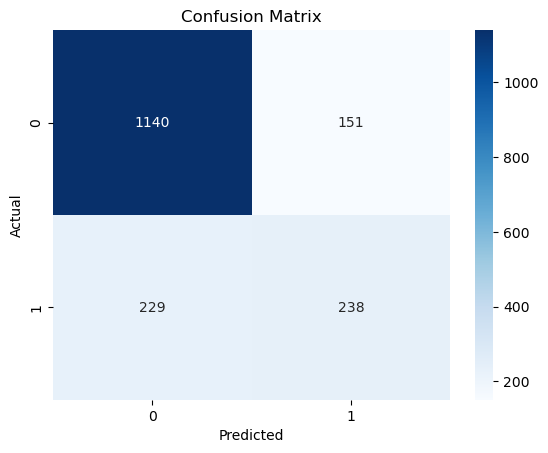

In [21]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

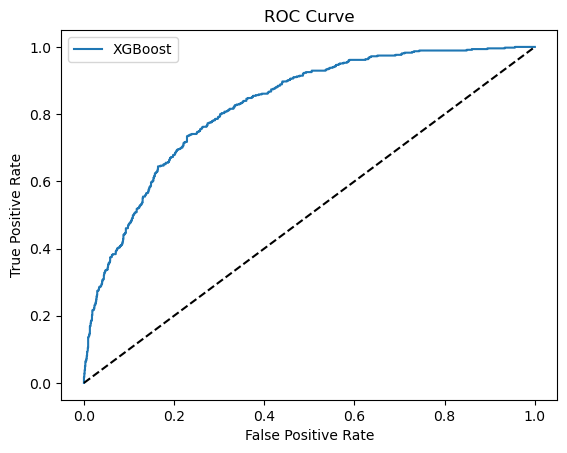

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [23]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
importance.head(10)

Contract            0.303063
TechSupport         0.131704
OnlineSecurity      0.115895
InternetService     0.080466
tenure              0.040784
PaperlessBilling    0.028203
MultipleLines       0.027893
StreamingTV         0.027698
MonthlyCharges      0.026961
OnlineBackup        0.026506
dtype: float32

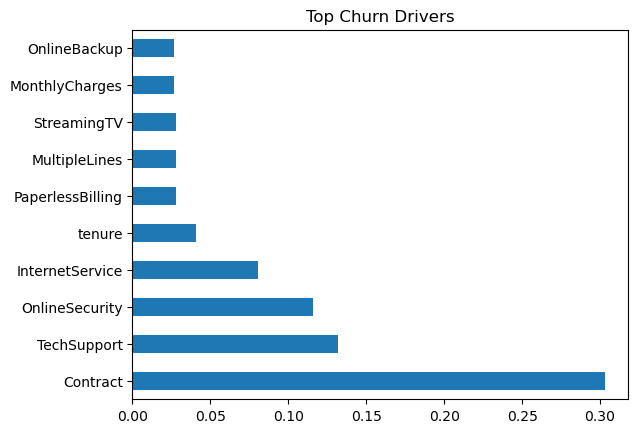

In [24]:
importance.head(10).plot(kind='barh')
plt.title("Top Churn Drivers")
plt.show()

In [25]:
churn_results = X_test.copy()
churn_results['Actual_Churn'] = y_test.values
churn_results['Churn_Probability'] = y_prob_xgb
churn_results.sort_values(
    by='Churn_Probability',
    ascending=False
).head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual_Churn,Churn_Probability
4517,0,1,1,0,11,1,2,1,0,0,...,0,2,2,0,1,2,99.55,1131.20,1,0.963667
2631,1,1,1,0,7,1,2,1,0,0,...,0,2,2,0,1,2,99.25,665.45,1,0.959296
4585,0,1,0,0,1,1,2,1,0,0,...,0,0,2,0,1,2,85.05,85.05,1,0.955154
5826,0,0,1,0,1,1,0,1,0,0,...,0,2,0,0,1,0,79.35,79.35,1,0.937598
3380,1,1,1,0,1,1,2,1,0,0,...,0,2,2,0,1,2,95.10,95.10,1,0.936782
1073,1,0,0,0,7,1,2,1,0,0,...,0,2,2,0,1,0,98.05,713.00,1,0.933304
3727,0,0,0,0,3,1,2,1,0,0,...,0,2,2,0,1,2,96.60,291.90,1,0.931901
2753,0,0,0,0,1,1,2,1,0,0,...,0,2,2,0,0,3,95.65,95.65,1,0.924768
3159,1,1,0,0,3,1,2,1,0,0,...,0,2,2,0,1,2,94.85,335.75,0,0.921143
2797,1,0,0,0,3,1,2,1,0,0,...,0,2,2,0,1,2,100.95,329.95,1,0.918187


In [29]:
# Assistant
import os

# Create the dashboard directory if it doesn't exist
os.makedirs("dashboard", exist_ok=True)

# Now save the file
churn_results.to_csv("dashboard/churn_predictions.csv", index=False)


The correction adds two important steps:
1. Import the `os` module to work with directories
2. Use `os.makedirs()` with `exist_ok=True` to create the "dashboard" directory if it doesn't exist
   - The `exist_ok=True` parameter prevents errors if the directory already exists

In [34]:
# Assistant
import streamlit as st
import joblib
import os

st.title("Customer Churn Prediction System")

# Check if model file exists, if not, show error message
model_path = "model/churn_model.pkl"
if os.path.exists(model_path):
    model = joblib.load(model_path)
    
    user_input = st.number_input("Monthly Charges", min_value=0.0)
    if st.button("Predict"):
        prediction = model.predict([[user_input]])
        st.write("Churn Risk:", prediction)
else:
    st.error(f"Model file not found at '{model_path}'. Please check the file path or train the model first.")
    # You might want to add instructions for the user on how to get or create the model
    st.info("Make sure the model file exists in the correct directory or update the path in the code.")

2026-01-12 13:11:13.182 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 13:11:13.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 13:11:13.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 13:11:13.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 13:11:13.190 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 13:11:13.192 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [35]:
import os
os.getcwd()


'C:\\Users\\User'

In [36]:
os.listdir()


['.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.m2',
 '.matplotlib',
 '.ms-ad',
 '.nbi',
 '.spyder-py3',
 '.vscode',
 'anaconda3',
 'AppData',
 'Application Data',
 'category_sales.csv',
 'Contacts',
 'Cookies',
 'dashboard',
 'Documents',
 'Downloads',
 'Favorites',
 'Links',
 'Local Settings',
 'ML_Task1.ipynb',
 'ML_Task2.ipynb',
 'monthly_sales.csv',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{6e0e9d46-eea3-11ef-967f-a3806f4a4cbd}.TM.blf',
 'NTUSER.DAT{6e0e9d46-eea3-11ef-967f-a3806f4a4cbd}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{6e0e9d46-eea3-11ef-967f-a3806f4a4cbd}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 'PrintHood',
 'Recent',
 'sales_forecast.csv',
 'Saved Games',
 'Searches',
 'SendTo',
 'Start Menu',
 'Templates',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 'Videos']

In [37]:
os.makedirs("dashboard", exist_ok=True)


In [38]:
churn_results.to_csv("dashboard/churn_predictions.csv", index=False)
